<a href="https://colab.research.google.com/github/ShangWeiKuo/Portfolio/blob/main/Python/Regression/Time%20Series/Energy_forecast_LSTM_Hypertune_Bootstrap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tsmoothie
!pip install keras-hypetune
!pip install keras-tuner

     |████████████████████████████████| 98 kB 3.0 MB/s 


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tsmoothie.smoother import *
from tsmoothie.utils_func import create_windows

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers import Adam
# from kerashypetune import KerasGridSearch
# from skopt import BayesSearchCV
import keras_tuner as kt
from kerastuner.tuners import BayesianOptimization
from pandas import read_csv

import numpy as np
import pickle

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


In [ ]:
window_shape = 7
time_h = 1

In [ ]:
import rpy2 
%load_ext rpy2.ipython

In [ ]:
%%R
require(readr)
require(dplyr)
df <- read_csv("/content/drive/MyDrive/test/energy_dataset.csv")
df <- df[, which(colnames(df) == 'total load actual')] %>% na.omit()

Rows: 35064 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (26): generation biomass, generation fossil brown coal/lignite, generat...
lgl   (2): generation hydro pumped storage aggregated, forecast wind offshor...
dttm  (1): time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
%%R
install.packages("forecast"); library(forecast)

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/xts_0.12.1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 517875 bytes (505 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =


In [ ]:
# 引進中文字體檔案
import matplotlib.font_manager as fm
path = os.path.join(os.getcwd(), '/content/drive/MyDrive/test/SimHei.ttf')
fontprop = fm.FontProperties(fname=path, size=12)

In [ ]:
sample_num = 11

In [ ]:
%%R
sample_num = 11
ts_df <- matrix(1:500, ncol = 1, nrow = 500)
ts_df <- ts(df, frequency = 1)
# Train:80% Validation:10% Test:10%
train <- ts_df[1:350, ] %>% data.frame()
validation <- ts_df[351:450, ] %>% data.frame()
test <- ts_df[451:500, ] %>% data.frame()

colnames(train) <- colnames(df)
colnames(validation) <- colnames(df)
colnames(test) <- colnames(df)

cols = colnames(train)

Max = unname(apply(train[cols], 2, max)) # 對每個col算max
Min = unname(apply(train[cols], 2, min)) # 對每個col算min

# for(i in c(1:1)){
#   a = cols[i]
#   if(Max[i] != 0){
#     train[a] = (train[a] - Min[i]) / (Max[i] - Min[i])
#     validation[a] = (validation[a] - Min[i]) / (Max[i] - Min[i])
#     test[a] = (test[a] - Min[i]) / (Max[i] - Min[i])
#   }
# }

a = cols
train[a] = (train[a] - Min) / (Max - Min)
validation[a] = (validation - Min) / (Max - Min)
test[a] = (test[a] - Min) / (Max - Min)

### BOOTSTRAP ###
train_boot_df = bld.mbb.bootstrap(train, sample_num) %>% data.frame()

In [ ]:
train_boot_df=%R train_boot_df
train=%R train
validation=%R validation
test=%R test
cols=%R cols
Max=%R Max
Min=%R Min

In [ ]:
bts_2d = []
bts_3d = []

In [ ]:
# for i in range(1):
#   for j in range(1, sample_num):
#     bts_3d.append(train_boot_df.iloc[:, j+(sample_num*i)])
#   bts_2d.append(bts_3d)
#   bts_3d = []

for j in range(1, sample_num):
  bts_3d.append(train_boot_df.iloc[:, j])
bts_2d.append(bts_3d)

bts_2d = np.stack(bts_2d, axis=-1)
bts_2d.shape

(10, 350, 1)

In [ ]:
bts_2d_y = bts_2d[:, :, 0].reshape((bts_2d.shape[0], bts_2d.shape[1], 1))
train_y = pd.DataFrame(train['total load actual'])
validation_y = pd.DataFrame(validation['total load actual'])
test_y = pd.DataFrame(test['total load actual'])

In [ ]:
### CREATE TRAIN/VALIDATION WINDOWS W/ BOOTSTRAP ###

_X = create_windows(train[cols], window_shape=window_shape, end_id=-time_h)
_y = create_windows(train_y, window_shape=time_h, start_id=window_shape)
X_val = create_windows(validation[cols], window_shape=window_shape, end_id=-time_h)
y_val = create_windows(validation_y, window_shape=time_h, start_id=window_shape)
# _X_train, _X_val, _y_train, _y_val = train_test_split(_X, _y, test_size=0.2, shuffle=False)
# X_train, X_val, y_train, y_val = [_X_train], [_X_val], [_y_train], [_y_val]
X_train, y_train = [_X], [_y]

for i in range(bts_2d.shape[0]):

    _X = create_windows(bts_2d[i], window_shape=window_shape, end_id=-time_h)
    _y = create_windows(bts_2d_y[i], window_shape=time_h, start_id=window_shape)
    # _X_train, _X_val, _y_train, _y_val = train_test_split(_X, _y, test_size=0.2, shuffle=False)
    # X_train.append(_X_train); X_val.append(_X_val)
    # y_train.append(_y_train); y_val.append(_y_val)
    X_train.append(_X)
    y_train.append(_y)
    
# X_train = np.concatenate(X_train); X_val = np.concatenate(X_val)
# y_train = np.concatenate(y_train); y_val = np.concatenate(y_val)
X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(3773, 7, 1) (3773, 1, 1)
(93, 7, 1) (93, 1, 1)


In [ ]:
### CREATE TEST WINDOWS ###

X_test = create_windows(test[cols], window_shape=window_shape, end_id=-time_h)
y_test = create_windows(test_y, window_shape=time_h, start_id=window_shape)

In [ ]:
def get_model_mae(hp):
    
    inp = Input((window_shape, len(cols)))
    x = LSTM(units=hp.Int('lstm1', min_value=32, max_value=128, step=16), activation='tanh', 
               return_sequences=True)(inp)
    x = LSTM(units=hp.Int('lstm2', min_value=32, max_value=160, step=32), activation='tanh', 
               return_sequences=False)(x)
    x = Dense(7, activation='linear')(x)
    out = Dense(1)(x)
    
    model = Model(inp, out)
    model.summary()
    model.compile(Adam(hp.Choice('learning_rate', values=[1e-4, 1e-3])), loss='mae', metrics=['mae'])
    
    return model

In [ ]:
es = EarlyStopping(patience=10, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel_mae = get_model_mae
bayes_mae = kt.tuners.BayesianOptimization(hypermodel_mae, objective='mae', seed=2021, max_trials=3)
bayes_mae.search(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[es])

Trial 3 Complete [00h 01m 25s]
mae: 0.03773178905248642

Best mae So Far: 0.03773178905248642
Total elapsed time: 00h 02m 51s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get best hyperparameters
bestHP = bayes_mae.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
model = bayes_mae.hypermodel.build(bestHP)
History = model.fit(X_train, y_train,
           validation_data=(X_val, y_val), 
           epochs=50, 
           verbose=2, 
           workers=8, 
           callbacks=[es])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7, 1)]            0         
                                                                 
 lstm_2 (LSTM)               (None, 7, 128)            66560     
                                                                 
 lstm_3 (LSTM)               (None, 160)               184960    
                                                                 
 dense_2 (Dense)             (None, 7)                 1127      
                                                                 
 dense_3 (Dense)             (None, 1)                 8         
                                                                 
Total params: 252,655
Trainable params: 252,655
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
118/118 - 8s - loss: 0.1483 - mae: 0.1483 

In [ ]:
pred_boot_mae = model.predict(X_test)
pred_boot_mae

array([[0.5921759 ],
       [0.9357948 ],
       [0.9919089 ],
       [0.9927932 ],
       [1.0290363 ],
       [0.98923135],
       [0.9746745 ],
       [0.9939728 ],
       [0.86113054],
       [0.894743  ],
       [0.9154783 ],
       [0.967914  ],
       [1.1358901 ],
       [1.1424302 ],
       [1.0846796 ],
       [0.9984795 ],
       [0.7543091 ],
       [0.5482638 ],
       [0.41394675],
       [0.313666  ],
       [0.28949785],
       [0.3029429 ],
       [0.315133  ],
       [0.3711258 ],
       [0.6016721 ],
       [0.9382491 ],
       [1.0059781 ],
       [1.0182998 ],
       [1.0337596 ],
       [0.9947009 ],
       [0.9603735 ],
       [0.99112487],
       [0.8684558 ],
       [0.91323316],
       [0.9142944 ],
       [0.9821436 ],
       [1.1136991 ],
       [1.1391884 ],
       [1.0825136 ],
       [0.9964525 ],
       [0.75863147],
       [0.5780953 ],
       [0.43399432]], dtype=float32)

In [ ]:
pred_boot_mae = ((Max - Min) * pred_boot_mae) + Min

In [ ]:
y_test = np.squeeze(y_test, -1)
y_test = ((Max - Min) * y_test) + Min

In [ ]:
print("Bootstrapped Many-to-one LSTMs' MAPE = ", np.mean(np.abs((y_test - pred_boot_mae) / y_test)) * 100)

Bootstrapped Many-to-one LSTMs' MAPE =  1.9814859880391884


In [ ]:
print("Bootstrapped Many-to-one LSTMs' sMAPE = ", np.mean(np.abs((y_test - pred_boot_mae) / (y_test + pred_boot_mae))) * 200)

Bootstrapped Many-to-one LSTMs' sMAPE =  2.015252954180806


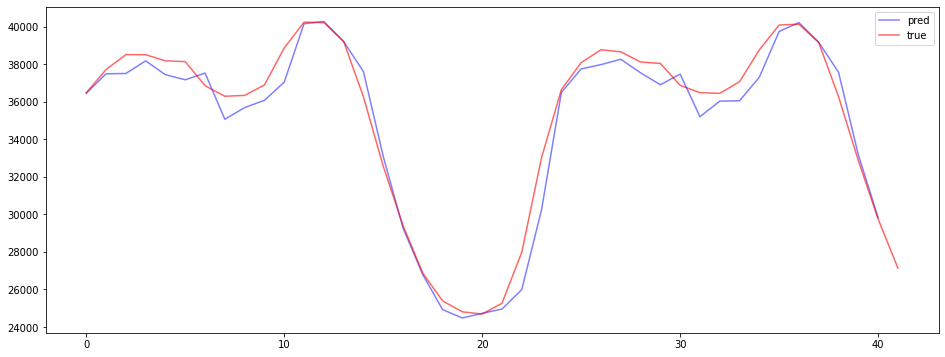

In [ ]:
### PLOT PREDICTIONS ON TEST ###

plt.figure(figsize=(16,6))

for t_h in range(time_h):
    plt.plot(pred_boot_mae[(time_h-t_h):-(t_h+1),], 
             c='blue', alpha=1-1/(time_h+1)*(t_h+1),
             label=f"pred")

plt.plot(y_test[time_h:], c='red', alpha=0.6, label='true')

plt.legend(); plt.show()